In [2]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# Завантаження датасету
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Нормалізація даних
x_train = x_train / 255.0
x_test = x_test / 255.0

# Перетворення міток у категорії
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Вибір кількості нейронів у першому шарі
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation='relu'))
    
    # Вибір кількості нейронів у другому шарі
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                    activation='relu'))
    
    # Вихідний шар
    model.add(Dense(10, activation='softmax'))

    # Вибір оптимізатора
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [4]:
from keras_tuner import RandomSearch

# Налаштування тюнера
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Кількість спроб для підбору
    executions_per_trial=3,  # Кількість запусків на кожній комбінації
    directory='my_tuner_dir',
    project_name='fashion_mnist_tuning')

# Пошук найкращих гіперпараметрів
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Trial 5 Complete [00h 01m 24s]
val_accuracy: 0.862933337688446

Best val_accuracy So Far: 0.8847666581471761
Total elapsed time: 00h 07m 53s


In [5]:
# Отримання найкращої моделі
best_model = tuner.get_best_models(num_models=1)[0]

# Виведення архітектури найкращої моделі
best_model.summary()

# Тренування найкращої моделі
history = best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 160)               125600    
                                                                 
 dense_1 (Dense)             (None, 128)               20608     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 147498 (576.16 KB)
Trainable params: 147498 (576.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2224 - accuracy: 0.9153 - val_loss: 0.3312 - val_accuracy: 0.8874
Epoc

Результати показали, що після тюнингу точність на тренувальних даних зросла до 93.54%, тоді як точність на валідаційних даних залишилася на рівні 88.35%.

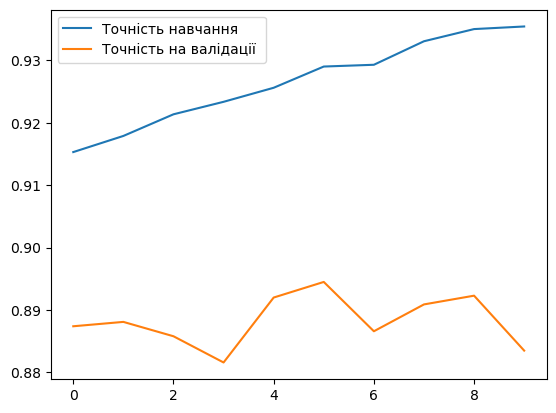

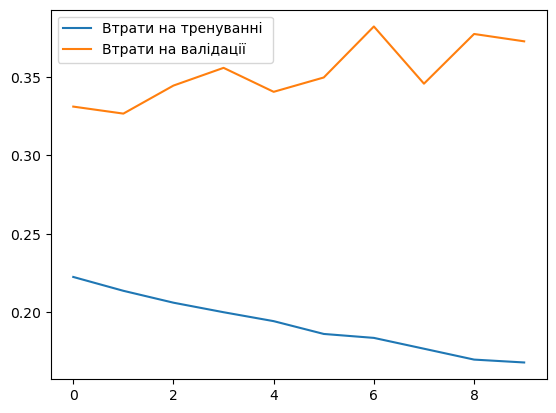

In [7]:
import matplotlib.pyplot as plt

# Графіки точності
plt.plot(history.history['accuracy'], label='Точність навчання ')
plt.plot(history.history['val_accuracy'], label='Точність на валідації ')
plt.legend()
plt.show()

# Графіки втрат
plt.plot(history.history['loss'], label='Втрати на тренуванні ')
plt.plot(history.history['val_loss'], label='Втрати на валідації ')
plt.legend()
plt.show()


Графіки показують, що модель демонструє хороші результати на тренувальних даних, проте на валідаційних даних спостерігається нестабільність. Це може свідчити про переобучення моделі.